In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# For adjacency heatmaps
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [ ]:
# Example program: users can replace this with their own CSV
program = pd.DataFrame({
    "room_name": ["Living Room", "Kitchen", "Bedroom 1", "Bedroom 2", "Bathroom"],
    "area_m2": [25, 12, 14, 14, 6],
    "zone": ["public", "public", "private", "private", "service"]
})

program

,room_name,area_m2,zone
0,Living Room,25,public
1,Kitchen,12,public
2,Bedroom 1,14,private
3,Bedroom 2,14,private
4,Bathroom,6,service


In [ ]:
# Adjacency weights:
# 0 = no preference
# 1 = prefer near
# 2 = must be adjacent

rooms = program["room_name"].tolist()
n = len(rooms)

adj_matrix = pd.DataFrame(0, index=rooms, columns=rooms)

# Example preferences
adj_matrix.loc["Living Room", "Kitchen"] = 2
adj_matrix.loc["Bedroom 1", "Bathroom"] = 1
adj_matrix.loc["Bedroom 2", "Bathroom"] = 1

# Make symmetric
adj_matrix = adj_matrix.combine(adj_matrix.T, np.maximum)

adj_matrix

,Living Room,Kitchen,Bedroom 1,Bedroom 2,Bathroom
Living Room,0,2,0,0,0
Kitchen,2,0,0,0,0
Bedroom 1,0,0,0,0,1
Bedroom 2,0,0,0,0,1
Bathroom,0,0,1,1,0


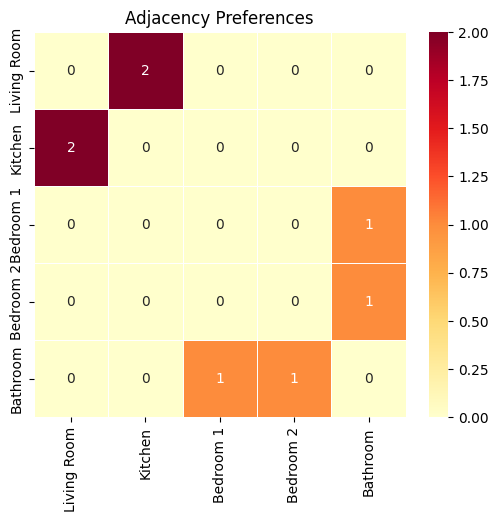

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(adj_matrix, annot=True, cmap="YlOrRd", linewidths=.5)
plt.title("Adjacency Preferences")
plt.show()

In [ ]:
GRID_W = 20
GRID_H = 12
CELL_SIZE = 0.5  # meters per grid cell

MAX_ITERS = 800
TEMP_START = 5.0
TEMP_END = 0.1

In [ ]:
def random_layout(program):
    layout = {}
    for _, row in program.iterrows():
        name = row["room_name"]
        area = row["area_m2"]

        # Approximate width/height from area
        w = int(np.sqrt(area) / CELL_SIZE)
        h = int(np.sqrt(area) / CELL_SIZE)

        # Random placement within grid
        x = random.randint(0, GRID_W - w - 1)
        y = random.randint(0, GRID_H - h - 1)

        layout[name] = {"x": x, "y": y, "w": w, "h": h}
    return layout

In [ ]:
def overlaps(a, b):
    return not (a["x"] + a["w"] <= b["x"] or
                b["x"] + b["w"] <= a["x"] or
                a["y"] + a["h"] <= b["y"] or
                b["y"] + b["h"] <= a["y"])

In [ ]:
def fitness(layout, program, adj_matrix):
    score = 0

    # 1. Overlap penalty
    rooms = list(layout.keys())
    for i in range(len(rooms)):
        for j in range(i+1, len(rooms)):
            if overlaps(layout[rooms[i]], layout[rooms[j]]):
                score -= 50  # heavy penalty

    # 2. Area accuracy
    for _, row in program.iterrows():
        name = row["room_name"]
        target = row["area_m2"]
        actual = layout[name]["w"] * layout[name]["h"] * CELL_SIZE**2
        score -= abs(actual - target) / target

    # 3. Adjacency reward
    for a in rooms:
        for b in rooms:
            if a == b: continue
            weight = adj_matrix.loc[a, b]
            if weight > 0:
                ax, ay, aw, ah = layout[a].values()
                bx, by, bw, bh = layout[b].values()

                # Manhattan distance between room centers
                dist = abs((ax+aw/2) - (bx+bw/2)) + abs((ay+ah/2) - (by+bh/2))
                score += weight * (1 / (1 + dist))

    return score

In [ ]:
def mutate(layout):
    new = {k: v.copy() for k, v in layout.items()}
    room = random.choice(list(new.keys()))

    # Random move: shift or resize
    if random.random() < 0.5:
        # Shift
        new[room]["x"] = max(0, min(GRID_W - new[room]["w"], new[room]["x"] + random.randint(-2, 2)))
        new[room]["y"] = max(0, min(GRID_H - new[room]["h"], new[room]["y"] + random.randint(-2, 2)))
    else:
        # Resize (small tweak)
        new[room]["w"] = max(1, new[room]["w"] + random.randint(-1, 1))
        new[room]["h"] = max(1, new[room]["h"] + random.randint(-1, 1))

    return new

In [ ]:
def simulated_annealing(program, adj_matrix):
    layout = random_layout(program)
    best = layout
    best_score = fitness(layout, program, adj_matrix)

    for i in range(MAX_ITERS):
        T = TEMP_START * (TEMP_END / TEMP_START) ** (i / MAX_ITERS)

        candidate = mutate(layout)
        f_old = fitness(layout, program, adj_matrix)
        f_new = fitness(candidate, program, adj_matrix)

        if f_new > f_old or random.random() < np.exp((f_new - f_old) / T):
            layout = candidate

        if f_new > best_score:
            best = candidate
            best_score = f_new

        if i % 100 == 0:
            print(f"Iter {i}, Best Score: {best_score:.3f}")

    return best, best_score

In [ ]:
results = []
for seed in range(5):
    random.seed(seed)
    np.random.seed(seed)
    layout, score = simulated_annealing(program, adj_matrix)
    results.append((layout, score))

results

Iter 0, Best Score: -199.948
Iter 100, Best Score: -149.632
Iter 200, Best Score: -1.323
Iter 300, Best Score: -1.323
Iter 400, Best Score: -1.118
Iter 500, Best Score: -0.635
Iter 600, Best Score: -0.355
Iter 700, Best Score: -0.355
Iter 0, Best Score: -498.929
Iter 100, Best Score: -100.991
Iter 200, Best Score: -51.793
Iter 300, Best Score: -51.793
Iter 400, Best Score: -51.793
Iter 500, Best Score: -51.793
Iter 600, Best Score: -51.793
Iter 700, Best Score: -51.793
Iter 0, Best Score: -448.262
Iter 100, Best Score: -149.933
Iter 200, Best Score: -101.623
Iter 300, Best Score: -101.297
Iter 400, Best Score: -51.155
Iter 500, Best Score: -1.921
Iter 600, Best Score: -1.437
Iter 700, Best Score: -1.142
Iter 0, Best Score: -398.918
Iter 100, Best Score: -100.967
Iter 200, Best Score: -100.967
Iter 300, Best Score: -1.413
Iter 400, Best Score: -0.953
Iter 500, Best Score: -0.953
Iter 600, Best Score: -0.953
Iter 700, Best Score: -0.953
Iter 0, Best Score: -399.580
Iter 100, Best Score: 

[({'Living Room': {'x': 2, 'y': 0, 'w': 1, 'h': 12},
   'Kitchen': {'x': 0, 'y': 0, 'w': 2, 'h': 11},
   'Bedroom 1': {'x': 11, 'y': 0, 'w': 3, 'h': 17},
   'Bedroom 2': {'x': 4, 'y': 3, 'w': 5, 'h': 10},
   'Bathroom': {'x': 15, 'y': 2, 'w': 6, 'h': 4}},
  np.float64(0.018268398268398267)),
 ({'Living Room': {'x': 7, 'y': 0, 'w': 14, 'h': 12},
   'Kitchen': {'x': 5, 'y': 3, 'w': 2, 'h': 4},
   'Bedroom 1': {'x': 9, 'y': 0, 'w': 4, 'h': 14},
   'Bedroom 2': {'x': 2, 'y': 0, 'w': 3, 'h': 17},
   'Bathroom': {'x': 0, 'y': 3, 'w': 2, 'h': 6}},
  np.float64(-51.202619047619045)),
 ({'Living Room': {'x': 5, 'y': 0, 'w': 6, 'h': 10},
   'Kitchen': {'x': 11, 'y': 0, 'w': 16, 'h': 3},
   'Bedroom 1': {'x': 0, 'y': 5, 'w': 5, 'h': 5},
   'Bedroom 2': {'x': 12, 'y': 6, 'w': 8, 'h': 6},
   'Bathroom': {'x': 12, 'y': 4, 'w': 6, 'h': 2}},
  np.float64(-0.8800307219662061)),
 ({'Living Room': {'x': 6, 'y': 1, 'w': 3, 'h': 10},
   'Kitchen': {'x': 9, 'y': 7, 'w': 8, 'h': 6},
   'Bedroom 1': {'x': 11,

In [ ]:
def plot_layout(layout, title="Layout"):
    plt.figure(figsize=(8,5))
    ax = plt.gca()

    for name, r in layout.items():
        rect = Rectangle((r["x"], r["y"]), r["w"], r["h"], fill=True, alpha=0.4)
        ax.add_patch(rect)
        plt.text(r["x"] + r["w"]/2, r["y"] + r["h"]/2, name,
                 ha="center", va="center", fontsize=8)

    plt.xlim(0, GRID_W)
    plt.ylim(0, GRID_H)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

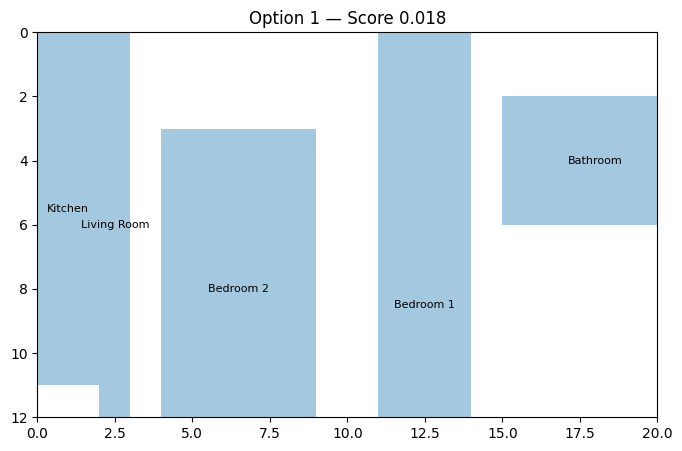

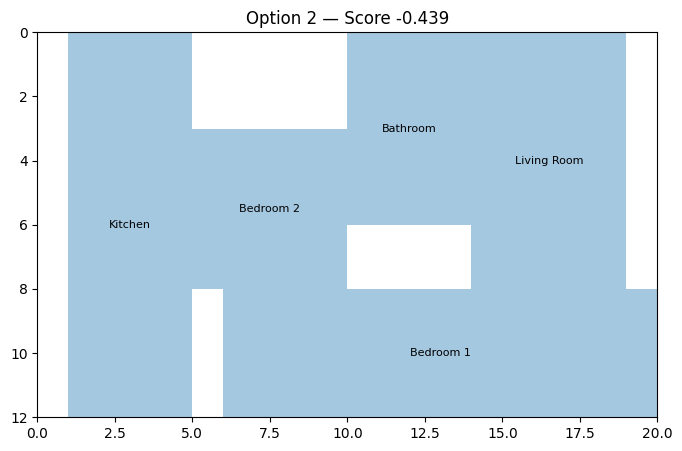

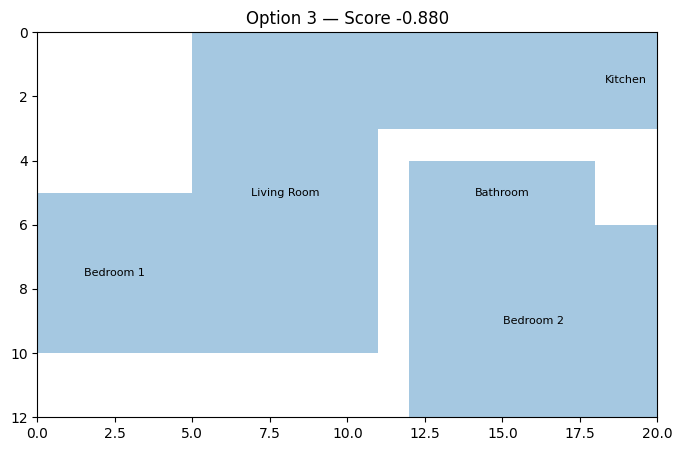

In [ ]:
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
top3 = sorted_results[:3]

for i, (layout, score) in enumerate(top3):
    plot_layout(layout, title=f"Option {i+1} — Score {score:.3f}")